<a href="https://colab.research.google.com/github/ciresimo/Leap-Camera-for-drone-control/blob/main/GestureRecognitionNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
MODEL_STATE_PATH = "/content/drive/MyDrive/UniTrento/Unmanned/data"
DATA_PATH = "/content/data"

NB_FEATURES = 17

gestures = ['ECL', 'ECR', 'P1L','P1R', 'P2L', 'P2R', 'R1L', 'R2L', 'Y1R', 'Y2R']
nb_gestures = len(gestures)

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
from google.colab import files
import os

if not os.path.exists(DATA_PATH):
  os.makedirs(DATA_PATH)

# if os.path.exists(DATA_PATH + ".zip") is False:
if not os.path.exists(os.path.join(DATA_PATH, "data.zip")):
  uploaded = files.upload()
  !mv data.zip {DATA_PATH} # Move the zip file to DATA_PATH
  !unzip {DATA_PATH}/data.zip -d {DATA_PATH}


In [17]:
from pyparsing import Any
import torch.utils.data as data
import os
import csv

class GestureDataset(data.Dataset):
    def __init__(self) -> None:
        self.ids = list()

        for gesture in gestures:
            for root, subdirs, _ in os.walk(DATA_PATH + f"/{gesture}"):
              for subject in subdirs:
                  for _, _, files in os.walk(root + f"/{subject}"):
                      for file in files:
                          file_path = f"{root}/{subject}/{file}"
                          self.ids.append(file_path)

    def __getitem__(self, index) -> Any:
        with open(self.ids[index], mode='r') as csv_file:
            csv_reader = csv.DictReader(csv_file)
            line_count = 0
            input_tensor = torch.zeros(size=(100, NB_FEATURES), dtype=torch.float)
            for row in csv_reader:
                if line_count >= 0:
                  if len(row.values()) == 15:
                    fix = [x for x in row.values()] + [0.0, 0.0]
                    #print(fix)
                    input_tensor[line_count] = torch.tensor([float(x) for x in fix], dtype=torch.float)
                  elif len(row.values()) == 16:
                    fix = [x for x in row.values()] + [0.0]
                    #print(fix)
                    input_tensor[line_count] = torch.tensor([float(x) for x in fix], dtype=torch.float)
                  else:
                    input_tensor[line_count] = torch.tensor([float(x) for x in row.values()], dtype=torch.float)
                line_count += 1

            target_gesture = self.ids[index].split('/')[3]
            target_gesture = gestures.index(target_gesture)
            target = torch.zeros([nb_gestures], dtype=torch.float)
            target[target_gesture] = 1.0

            return (input_tensor.swapaxes(0, 1), target)

    def __len__(self):
        return len(self.ids)

In [18]:
import torch

class GestureNet(torch.nn.Module):
  def __init__(self, *args, **kwargs) -> None:
     super().__init__(*args, **kwargs)

     self.sequence = torch.nn.Sequential(
         torch.nn.BatchNorm1d(NB_FEATURES * 100),
         torch.nn.Linear(NB_FEATURES * 100, 300),
         torch.nn.ELU(),
         torch.nn.BatchNorm1d(300),
         torch.nn.Linear(300, 200),
         torch.nn.ELU(),
         torch.nn.BatchNorm1d(200),
         torch.nn.Linear(200, 120),
         torch.nn.ELU(),
         torch.nn.BatchNorm1d(120),
         torch.nn.Linear(120, 60),
         torch.nn.ELU(),
         torch.nn.BatchNorm1d(60),
         torch.nn.Linear(60, 30),
         torch.nn.ELU(),
         torch.nn.BatchNorm1d(30),
         torch.nn.Linear(30, 10),
         torch.nn.Softmax(),
     )

  def forward(self, x):
    x = torch.flatten(x, 1)

    return self.sequence(x)

class OldGestureNet(torch.nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.sequence = torch.nn.Sequential(
          torch.nn.Conv1d(NB_FEATURES, 6 * NB_FEATURES, 6, 1, padding=2),
          torch.nn.MaxPool2d(2),

          torch.nn.Conv1d(6 * NB_FEATURES // 2, 6 * NB_FEATURES * 5, 12, 2),
          torch.nn.MaxPool2d(2),

          torch.nn.Conv1d(6 * NB_FEATURES * 5 // 2, 6 * NB_FEATURES * 5 // 2 * 4, 9, 2),
          torch.nn.MaxPool2d((2, 1)),

          torch.nn.Linear(6 * NB_FEATURES * 5 // 2 * 4 // 2, 200),
          torch.nn.ELU(),
          torch.nn.Linear(200, 10),
          torch.nn.Softmax()
        )

    def forward(self, x):
        return self.sequence(x)


In [19]:
from torch.utils.data import Subset

def get_data(batch_size=32, transform=None, test_batch_size=256):
  full_data = GestureDataset()

  data_size = len(full_data)

  train_size = int(0.6 * data_size)
  val_size = int(0.2 * data_size)
  test_size = data_size - train_size - val_size

  training_data, validation_data, test_data = torch.utils.data.random_split(full_data, [train_size, val_size, test_size])

  # shuffle true only for training as it helps it but is useless for validation and testing
  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

In [20]:
import torchvision

def training_step(net, data_loader, optimizer, cost_function, device='cuda'):
  # set the network to training mode
  net.train()
  total_batches = len(data_loader)
  train_accuracy = 0
  train_loss = 0
  for batch_idx, (inputs, targets) in enumerate(data_loader):
    predicted = net(inputs)
    pred = torch.argmax(predicted, dim=1)
    loss = cost_function(predicted, targets)

    tgts = torch.argmax(targets, dim=1)
    num_correct = torch.sum(torch.eq(pred, tgts)).item()

    batch_accuracy = num_correct / inputs.shape[0] * 100

    loss.backward()

    optimizer.step()

    optimizer.zero_grad()

    train_loss += loss.item()

#    print(f"\rbatch {batch_idx+1} / {total_batches} train accuracy: {batch_accuracy}% and loss {loss}", end="")
    # add up the batch accuracy to the total
    train_accuracy += batch_accuracy

    if not torch.isfinite(loss).all():
      print("Loss is {}, stopping training".format(loss))
      return False, None, None
  # divide the total accuracy by the batches number to get the mIOU accuracy
  train_accuracy /= total_batches
  train_loss /= total_batches

  return True, train_accuracy, train_loss

In [21]:
def test_step(net, data_loader, cost_function, device='cuda'):
  # set the network to training mode
  net.eval()

  with torch.no_grad():
    test_accuracy = 0

    test_loss = 0
    total_batches = len(data_loader)
    for batch_idx, (inputs, targets) in enumerate(data_loader):
      #print(f"\rtest batch: {batch_idx + 1} / {total_batches}", end="")
      predicted = net(inputs)

      pred = torch.argmax(predicted, 1)
      tgts = torch.argmax(targets, 1)
      batch_accuracy = torch.sum(torch.eq(pred, tgts)) / inputs.shape[0] * 100

      loss = cost_function(predicted, targets)
      test_loss += loss.item()

      test_accuracy += batch_accuracy

    # return the mean accuracy for the whole data
    test_accuracy /= total_batches

    test_loss /= total_batches

    return test_accuracy, test_loss


In [22]:
import matplotlib.pyplot as plt

def plot_datas(title, data : list, x_label, y_label):
    plt.figure(figsize=(10,5))
    plt.title(title)
    for d in data:
        plt.plot(d[0], label=d[1])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

In [23]:
def main(
      load_and_skip_training=False,
      device='cuda:0',
      epochs=50,
      hyperparameters={}
    ):

  model = GestureNet().to(device).float()

  if load_and_skip_training:
    try:
      model.load_state_dict(torch.load(MODEL_STATE_PATH))
      print(f"model loaded from {MODEL_STATE_PATH}")
    except:
      print("model save not found, starting from scratch")
    return model, 0, 0

  optimizer = torch.optim.AdamW(model.parameters(), lr=hyperparameters.get('learning_rate'), weight_decay=hyperparameters.get('weight_decay'))

  criterion = torch.nn.CrossEntropyLoss()

  train_loader, val_loader, test_loader = get_data(hyperparameters.get('batch_size'))

  train_accs = []
  train_losses = []

  val_accs = []
  val_losses = []

  max_val_acc_epoch = 0
  max_val_acc = 0

  for e in range(0, epochs):
    print(f"\rEpoch: {e+1} / {epochs}", end="")

    ok, train_acc, train_loss = training_step(model, train_loader, optimizer, criterion, device)
    if not ok:
      print("")
      print(f"Training stopped at epoch {e+1} / {epochs}")
      break

    #print("\rValidating the model on the VALIDATION set...", end="")
    val_acc, val_loss = test_step(model, val_loader, criterion, device)

    if val_acc > max_val_acc:
      max_val_acc = val_acc
      max_val_acc_epoch = e+1
      torch.save(model.state_dict(), MODEL_STATE_PATH + f"_epoch_{max_val_acc_epoch}")

    train_accs.append(train_acc)
    train_losses.append(train_loss)

    val_accs.append(val_acc)
    val_losses.append(val_loss)

  plot_datas('Accuracy over epochs', [(train_accs, "train"), (val_accs, "validation")], 'Epoch', 'Accuracy in %')
  plot_datas('Loss over epochs', [(train_losses, "train"), (val_losses, "validation")], 'Epoch', 'Loss')

  model.load_state_dict(torch.load(MODEL_STATE_PATH + f"_epoch_{max_val_acc_epoch}"))
  test_acc, test_loss = test_step(model, test_loader, criterion, device)

  print(f"Test set accuracy: {test_acc}%.\nTest set loss: {test_loss}")

  return model, max_val_acc, max_val_acc_epoch

In [24]:
optimized_hyperparameters = {
    'learning_rate': 0.001,
    'weight_decay': 0.001,
    'batch_size': 32,
}

Epoch: 100 / 100

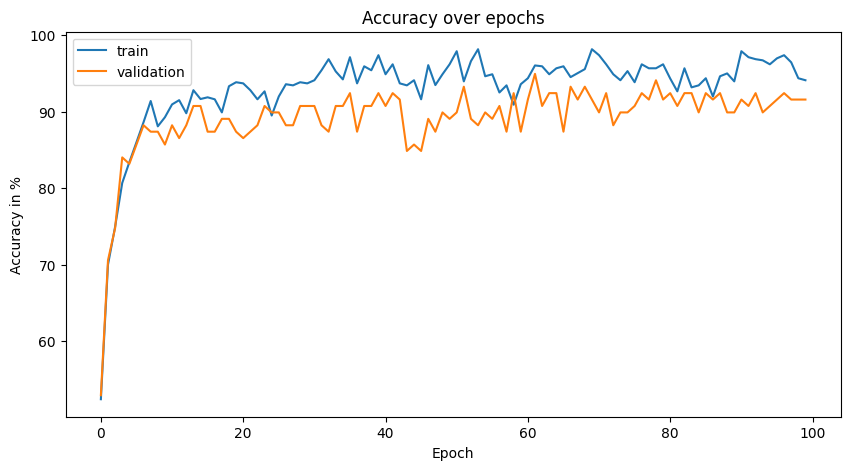

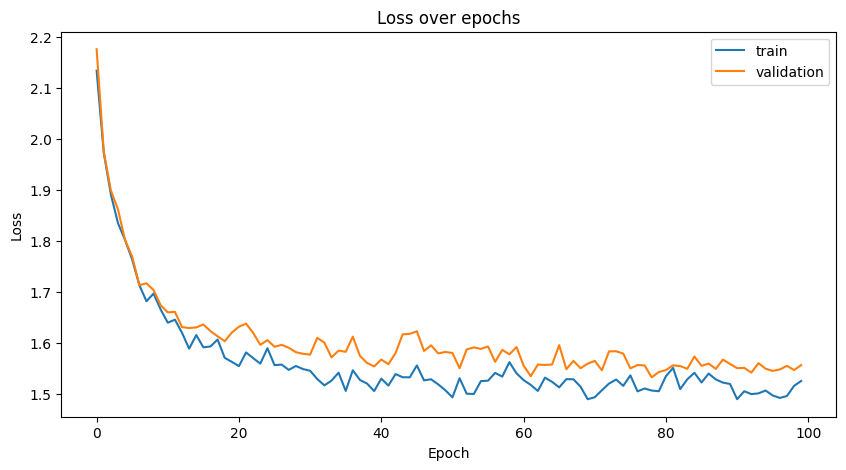

Test set accuracy: 91.73553466796875%.
Test set loss: 1.5550284385681152
max validation accuracy is 94.9579849243164% at epoch 62


In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# modify this variable, do not delete it
load_and_skip_training=False

model, max_val_acc, max_val_acc_epoch = main(load_and_skip_training=load_and_skip_training, device=device, epochs=100, hyperparameters=optimized_hyperparameters)

print(f"max validation accuracy is {max_val_acc}% at epoch {max_val_acc_epoch}")

In [26]:
dataset = GestureDataset()
print(len(dataset))
(tensor, gesture) = dataset.__getitem__(100)
batch_tensor = torch.zeros(size=(2,17,100))
batch_tensor[0] = tensor
net = GestureNet()
out = net(batch_tensor)
print(out.shape)

599
torch.Size([2, 10])


In [27]:
# pool of size=3, stride=2
m = torch.nn.MaxPool1d(2)
input = torch.randn(2, 102, 95)
output = m(input)
print(output.shape)

torch.Size([2, 102, 47])


In [28]:
# Example of target with class indices
loss = torch.nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()
# Example of target with class probabilities
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5).softmax(dim=1)
output = loss(input, target)
output.backward()
print(input)
print(target)
print(output)

tensor([[ 0.7296,  1.1827,  1.2364,  0.3435, -0.2206],
        [ 0.0803,  0.2624,  0.2005,  0.0064,  0.1346],
        [-0.5637, -0.0450, -1.2835, -1.1662, -1.1042]], requires_grad=True)
tensor([[0.3238, 0.1086, 0.0808, 0.4034, 0.0834],
        [0.0999, 0.5136, 0.1762, 0.1500, 0.0603],
        [0.1043, 0.3756, 0.0182, 0.0468, 0.4551]])
tensor(1.6419, grad_fn=<DivBackward1>)


In [29]:
# If needed download the model
# from google.colab import files
# files.download(MODEL_STATE_PATH + f"_epoch_{max_val_acc_epoch}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>